<a href="https://colab.research.google.com/github/hereagain-Y/TF_tutorial/blob/main/Newpca_binary_TCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.spatial import distance

from six.moves import xrange
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

# New section

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
s = []
my_file = open("/content/drive/My Drive/DL/VAE/Newdata/short_Normal.txt", "r")
content_list = my_file.read().splitlines()
content_list=np.array(content_list)
d= {} # bipphysics dictionary
with open("/content/drive/My Drive/DL/VAE/AAidx_PCA.txt") as f:
    next(f)
    for line in f.readlines():
        line=line.strip().split('\t') #
        AA=line[0]
        tag=0
        values=[]
        for PC in line[1:]:
            values.append(float(PC))
        if tag==1: 
            continue
        d[AA]=values

def normalize(d):
  result = {}
  for key, value in d.items():
    maxval = max(d[key])
    minval = min(d[key])
    newval=[]
    for number in value:

      newval.append((number-minval)/(maxval-minval))
    
    result[key] =newval
  return(result)

d_norm=normalize(d)
# new way to normalize 
data = d.items()
list_dat = list(d.values())
arr = np.array(list_dat)
ex = np.array(arr)
ex_norm = (ex-ex.min(axis=0))/(ex.max(axis=0)-ex.min(axis=0))

AAs=np.array(list(d.keys()))
new_pca = {}

for i in np.arange(20):
    new_pca[AAs[i]]=ex_norm[i]
  
# max length
#comp_seq=data["amino_acid"].tolist()

comp_seq=content_list

print(comp_seq)
max_len=-1 

for AA in comp_seq:
    if len(AA)>max_len:
        max_len=len(AA)
        #res=AA
print(max_len )

"""Load AA index data

# normalization
"""

PC_length=len(d_norm['C'])
def AAindexEncoding(Seq):
    length_seq=len(Seq)
    global max_len
    AAE=np.zeros([max_len,15])
    if length_seq<max_len:
        for amino in range(length_seq):
            AA=Seq[amino]# 
            AAE[amino,]=new_pca[AA] # add PC value 
            
        for amino in range(length_seq,max_len):
            AAE[amino,]=np.zeros(15)
    else: 
        for amino in range(length_seq): # zero padding
            AA=Seq[amino]# 
            AAE[amino,]=new_pca[AA]
        
    #AAE=np.transpose(AAE.astype(np.float32)) # row as PC. and column as AA sequence 
    return AAE 
  
def GetFeatures(file):
    #sequence=file['amino_acid'].tolist()
    #sequence=np.array(sequence)
    #sequence = file.read().splitlines()
    #sequence=np.array(sequence)
    hot_encode=[]
    for seq in file:
        hot_encode.append(AAindexEncoding(seq))
    hot_encode=np.array(hot_encode)
    result=np.array(hot_encode)
    return(result) # dimension: number of sequence [15*length(sequence)]

def reconstructSequence(dict,data):
  result = []
  for i in range(len(data)):
    currentSeq= ''
    dict_index=list(dict.keys())
    if(i%1000==0):
      print(str(i/len(data)*100)+'%')
    for j in range(len(data[i])):
      row = data[i][j]
      max_value= np.max(row)
      if max_value <= 0.1:
        continue
      #calculate distance
      dist = []
      for key, value in dict.items():
        dist.append(distance.euclidean(dict[key], row))
      currentSeq += dict_index[np.argmin(dist)]
    result.append(currentSeq)
  return result
def CompareSeq(dict,data,correct):
  result=[]
  result=reconstructSequence(dict,data)
  index = 0
  print("start comparing sequence")
  for i in range(len(result)):
    if result[i]==correct[i]:
      index += 1
  Accu=index/len(result)
  print(f'the accuracy is {Accu:.1%}')


r1=GetFeatures(content_list)

['LKPNTEA' 'AHIANYGY' 'PRPNTEA' ... 'VDVGYEQ' 'LAGQETQ' 'VVPNTEA']
13


In [5]:
r1

array([[[0.07030965, 0.40676752, 0.8684857 , ..., 0.50469855,
         0.59503819, 0.59367788],
        [0.83311257, 0.00431661, 0.5397168 , ..., 0.2385159 ,
         0.74577505, 0.35191302],
        [0.95036751, 0.87434867, 0.17176543, ..., 0.34823108,
         0.48280104, 0.66762789],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.50354548, 0.4076369 , 1.        , ..., 0.5111926 ,
         0.6006534 , 0.94119758],
        [0.5466722 , 0.23034084, 0.23674313, ..., 0.46698353,
         0.60350722, 0.57779154],
        [0.        , 0.54289831, 0.59825751, ..., 0.        ,
         0.327881  , 0.75923615],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0. 

In [6]:
kwargs = {'num_workers': 1, 'pin_memory': True} 
r1_transform=torch.from_numpy(r1) # from np to tensor
r1_transform=r1_transform.float()
r1_transform.shape
train_ds, test_ds =torch.utils.data.random_split(r1_transform, (int(0.8*len(r1_transform)), len(r1_transform)-int(0.8*len(r1_transform))))
print(train_ds, test_ds)

train_loader = DataLoader(dataset=train_ds, batch_size=1000)
test_loader  = DataLoader(dataset=test_ds,  batch_size=1000)
cuda = True
DEVICE = torch.device("cuda")

<torch.utils.data.dataset.Subset object at 0x7fe5bebbc690> <torch.utils.data.dataset.Subset object at 0x7fe5bebbc390>


In [7]:
#change parameter 
batch_size = 1000
x_dim= 195#660 # 44*15
#hidden_dim = 256

latent_dim = 128
lr = 1e-3

	Epoch 0 complete! 	Average Loss:  101.27676318359374 	Average Test Loss:  89.474712890625
	Epoch 100 complete! 	Average Loss:  79.4108779296875 	Average Test Loss:  79.44004296875
	Epoch 200 complete! 	Average Loss:  78.69944360351562 	Average Test Loss:  78.7359345703125
	Epoch 300 complete! 	Average Loss:  78.197095703125 	Average Test Loss:  78.228587890625
	Epoch 400 complete! 	Average Loss:  77.96493603515626 	Average Test Loss:  78.0150869140625
	Epoch 500 complete! 	Average Loss:  77.85914013671875 	Average Test Loss:  77.868400390625
	Epoch 600 complete! 	Average Loss:  77.74202368164063 	Average Test Loss:  77.8550751953125
	Epoch 700 complete! 	Average Loss:  77.67153686523437 	Average Test Loss:  77.788365234375
	Epoch 800 complete! 	Average Loss:  77.66088427734375 	Average Test Loss:  77.7152978515625
	Epoch 900 complete! 	Average Loss:  77.61592797851563 	Average Test Loss:  77.6784150390625
	Epoch 1000 complete! 	Average Loss:  77.59510180664063 	Average Test Loss:  77.

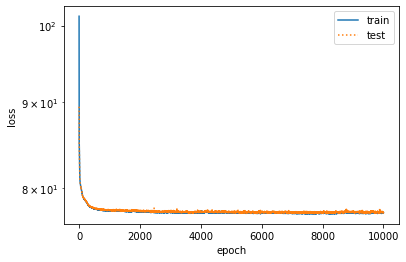

In [35]:
epochs = 10000

class Encoder(nn.Module):
    
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        self.hsize = int(1.5*input_dim)
        self.FC_input = nn.Linear(input_dim, self.hsize)
        self.FC_input1 = nn.Linear(self.hsize, self.hsize)
        #self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        #self.FC_input3 = nn.Linear(hidden_dim, hidden_dim2)
        self.FC_mean  = nn.Linear(self.hsize, latent_dim)
        self.FC_var   = nn.Linear (self.hsize, latent_dim)
        self.relu = nn.ReLU()  
        self.dropout1= nn.Dropout(p=0.3)
        self.dropout2 = nn.Dropout(p=0.3)     
        self.training = True
        
    def forward(self, x):
        h_       = self.relu(self.FC_input(x))
        h_       = self.dropout1(h_)
        h_       = self.relu(self.FC_input1(h_))
        #h_       = self.dropout1(h_)
        #h_       = self.relu(self.FC_input2(h_))
        #h_       = self.relu(self.FC_input3(h_))
        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)                     # encoder produces mean and log of variance 
                                                     #             (i.e., parateters of simple tractable normal distribution "q"
        
        return mean, log_var

class Decoder(nn.Module):
    def __init__(self, latent_dim,output_dim):
        super(Decoder, self).__init__()
        self.hsize = int(1.5*output_dim)
        self.FC_hidden1 = nn.Linear(latent_dim, self.hsize)
        #self.FC_hidden3 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(self.hsize, self.hsize)
        #self.FC_hidden = nn.Linear(hidden_dim, self.hsize)
        self.FC_output = nn.Linear(self.hsize, output_dim)      
        self.relu = nn.ReLU()
        self.dropout1= nn.Dropout(p=0.3)
       # self.dropout2 = nn.Dropout(p=0.3)
        
    def forward(self, x):
        h     = self.relu(self.FC_hidden1(x))
        h     = self.dropout1(h)
        #h     = self.relu(self.FC_hidden3(h))
        h     = self.relu(self.FC_hidden2(h))
        #h     = self.dropout1(h)
        #h     = self.relu(self.FC_hidden(h))
        x_hat = torch.sigmoid(self.FC_output(h))
        #x_hat = self.relu(self.FC_output(h))
        return x_hat

class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)        # sampling epsilon        
        z = mean + var*epsilon 
        #z  = mean                       # reparameterization trick
        return z
        
                
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var) ]
        x_hat = self.Decoder(z)
        
        return x_hat, mean, log_var

encoder = Encoder(input_dim=x_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim,output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

from torch.optim import Adam

BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    #MSELoss_criterion = nn.MSELoss()
    #reproduction_loss = MSELoss_criterion(x_hat, x) 
    # try MSE 
    #MSELoss_criterion = nn.MSELoss()
    #reproduction_loss = MSELoss_criterion(x_hat, x) 
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss + KLD, reproduction_loss


optimizer = Adam(model.parameters(), lr=lr)   

train_loss= [] # before epoch
testtoal_loss= []
reproduction1=[]
reproduction2=[]

def plotCurve(x_vals,y_vals,x_label, y_label,
              x2_vals=None, y2_vals=None, legend=None,figsize=(3.5,2.5)):
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        plt.semilogy(x2_vals, y2_vals, linestyle=':')
    
    if legend:
        plt.legend(legend)
for epoch in range(epochs):
    overall_loss = 0
    overall_testloss= 0
    overall_res = 0
    overall_testres= 0
    
    for batch_idx, x in enumerate(train_loader):
        x = x.view(len(x), x_dim)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss, reproduction_loss = loss_function(x, x_hat, mean, log_var)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        overall_loss += loss.item()
        overall_res += reproduction_loss.item()
    train_loss.append(overall_loss/len(train_ds))
    reproduction1.append(overall_res/len(train_ds))

      #test loss
    for batch_idx, x in enumerate(test_loader):
        x = x.view(len(x), x_dim)
        x = x.to(DEVICE)

        #optimizer.zero_grad()

        pred, mean, log_var = model(x)
        test_loss, test_reproduction= loss_function(x, pred, mean, log_var)
        overall_testloss += test_loss.item()
        overall_testres += test_reproduction.item()
    testtoal_loss.append(overall_testloss/len(test_ds))
    reproduction2.append(overall_testres/len(test_ds))

    if (epoch % 100 == 0):
      #print('====> Epoch %d done! Average Loss:  = %.2e, Average test loss = %.2e' % (epoch,overall_loss / (batch_idx*batch_size),overall_testloss/(batch_idx*batch_size)))
        
        
      print("\tEpoch", epoch , "complete!", "\tAverage Loss: ", train_loss[epoch],#overall_loss / (batch_idx*batch_size),
        "\tAverage Test Loss: " , testtoal_loss[epoch])
    
print("Finish!!")
print("plot curves")
plotCurve(range(1,epochs+1),train_loss,"epoch","loss",
          range(1,epochs+1),testtoal_loss,
          ['train','test'])


print('==train end===')

In [36]:
torch.save(model, '/content/drive/My Drive/DL/VAE/Newdata/VAE_extract_modify_Binary_model_1000_echo.apx')
model = torch.load('/content/drive/My Drive/DL/VAE/Newdata/VAE_extract_modify_Binary_model_1000_echo.apx')

In [37]:
my_file2 = open("/content/drive/My Drive/DL/VAE/Newdata/short_Normaltest.txt", "r")
content_list2 = my_file2.read().splitlines()

neww=np.array(content_list2)

#neww=[x for x in content_list2 if len(x)<=13]

neww=np.array(neww)
r2=GetFeatures(neww)
r2_transform=torch.from_numpy(r2).float() # change to tensor and float 
m2=r2_transform.view(len(r2_transform),195) # flatten 
#m2 = torch.from_numpy(m2).float()
#result = model(m2)[0] # 
result = model(m2.cuda())[0]
result2 = result.view( len(result),13,15 ).cpu().detach().numpy()


seq_decode=reconstructSequence(new_pca,result2)
#content_list2
seq_decode[:10]

0.0%
5.037529595486374%
10.075059190972748%
15.112588786459119%
20.150118381945497%
25.187647977431865%
30.225177572918238%
35.26270716840462%
40.30023676389099%
45.33776635937736%
50.37529595486373%
55.41282555035011%
60.450355145836475%
65.48788474132286%
70.52541433680923%
75.5629439322956%
80.60047352778199%
85.63800312326835%
90.67553271875472%
95.7130623142411%


['LGSAGSTDTQ',
 'AGSAGSTDTQ',
 'AGSAGSTDTQ',
 'QSSGGSTDTQ',
 'QSSGGGTDTQ',
 'QSSGSSSDTQ',
 'QSSGGSTDTQ',
 'QSSGGGSDTQ',
 'AGSSGGQETQ',
 'AGSSGGQETQ']

In [39]:
neww[:10]

array(['RGTSASTDTQ', 'QEFAGGTDTQ', 'QDFGGGTDTQ', 'QDRGQGADTQ',
       'QDPGQGADTQ', 'QEPGQGSDTQ', 'QEPGQGADTQ', 'QDPGGGADTQ',
       'QDPSGGAETQ', 'QDNSGGAETQ'], dtype='<U13')

In [31]:
seq_decode[:10]

['QSSSGGTDTQ',
 'QSSAGGTDTQ',
 'QSAGGSTDTQ',
 'QSSGGSTDTQ',
 'QSAGGGTDTQ',
 'QSASGGSDTQ',
 'QSSAGGTDTQ',
 'QSSGGGTDTQ',
 'AGAGGGQETQ',
 'QSSSGGSDTQ']

In [38]:
CompareSeq(new_pca,result2,neww)

0.0%
5.037529595486374%
10.075059190972748%
15.112588786459119%
20.150118381945497%
25.187647977431865%
30.225177572918238%
35.26270716840462%
40.30023676389099%
45.33776635937736%
50.37529595486373%
55.41282555035011%
60.450355145836475%
65.48788474132286%
70.52541433680923%
75.5629439322956%
80.60047352778199%
85.63800312326835%
90.67553271875472%
95.7130623142411%
start comparing sequence
the accuracy is 0.1%


In [18]:
a= neww[3]
b= seq_decode[3]

In [ ]:
len(seq_decode)

10000

In [ ]:
len(content_list2)

10000

In [ ]:
a


'IRNPETQ'

In [ ]:
b

'PSGSETQ'

In [19]:
def compare_percent (seq1,seq2):
  return float(sum(seq1[i]==seq2[i] for i in range(len(seq1)))/len(seq1))

In [20]:
compare_percent(seq_decode[1],neww[1])

0.0

In [21]:
def compare_percent (seq1,seq2):
  return float(sum(seq1[i]==seq2[i] for i in range(len(seq1)))/len(seq1))

def CoverageSeq(data,correct):
  print("start comparing sequence")
  percentage = []
  for i in range(len(data)):
    percentage.append(compare_percent(data[i],correct[i]))
  Accu = sum(percentage)/len(percentage)   
  print(f'the average coverage is {Accu:.1%}')

 
  

In [ ]:
with open(r'/content/drive/My Drive/DL/VAE/Newdata/Tumor_prediction.txt','w') as fp:
    fp.write('\n'.join(seq_decode))

In [34]:
CoverageSeq(seq_decode[:50],neww[:50])

start comparing sequence
the average coverage is 59.4%


In [26]:
new_pca

{'A': array([0.50354548, 0.4076369 , 1.        , 0.55951449, 0.73118242,
        0.43092049, 0.78203872, 0.36312716, 0.63041598, 0.2458337 ,
        0.51973429, 0.43396146, 0.5111926 , 0.6006534 , 0.94119758]),
 'C': array([0.31121817, 0.66882902, 0.24303985, 1.        , 1.        ,
        1.        , 0.6498213 , 0.11758461, 0.28151378, 0.70761651,
        0.63877004, 0.59669379, 0.48222483, 0.47926492, 0.55233719]),
 'D': array([1.        , 0.35242153, 0.45879071, 0.64595929, 0.88531876,
        0.21007324, 0.        , 0.37649839, 0.18366252, 0.31832004,
        0.57289266, 0.67644312, 0.04997744, 1.        , 0.44779209]),
 'E': array([0.84156162, 0.01472165, 0.74788582, 0.50782993, 0.99378639,
        0.36414319, 0.28450833, 0.24629134, 0.13982815, 0.39741824,
        0.44123645, 0.3951055 , 0.72998689, 0.07643977, 0.64214071]),
 'F': array([0.0453665 , 0.4453626 , 0.35492999, 0.49786522, 0.49910808,
        0.2526996 , 0.54564697, 0.58228714, 0.27279403, 0.30506733,
        0.70382

In [ ]:
d_norm

{'A': [0.07525231330089575,
  0.11110993247250554,
  1.0,
  0.10085171430385075,
  0.3362586030378956,
  0.08589557098930195,
  0.3166716257763159,
  0.07845695355133557,
  0.29558950944630463,
  0.0,
  0.17264524667274148,
  0.02519795885608285,
  0.21399362066317887,
  0.20352855444366297,
  0.315091708147771],
 'C': [0.0,
  0.7495696809258403,
  0.07865597242639141,
  1.0,
  0.7627030301724574,
  0.8168259804237982,
  0.4333259554067372,
  0.16777058828085453,
  0.33203232126086285,
  0.5724424696175718,
  0.4816359939467978,
  0.39170914029908754,
  0.4294503690415155,
  0.37686420256824266,
  0.3449489815613006],
 'D': [1.0,
  0.25640988772162693,
  0.32592183369372396,
  0.4200305281353341,
  0.5744582792254195,
  0.1560420670881465,
  0.0,
  0.3091207506859722,
  0.258039340323857,
  0.2882727977487466,
  0.3895335207450628,
  0.38763175831637187,
  0.18676139620557258,
  0.5451097643479257,
  0.2696370438467982],
 'E': [1.0,
  0.0,
  0.8519057393700852,
  0.4383574918534277,
  